# Twitter trolls - how Russia meddles with western democracies


## Abstract
Over the last several years there has been an attempt from Russian trolls to spread propaganda and fake news over social media in order to spread political ideas among the general population both nationally and internationally. Can these attempts be regarded as undermining the democracy of the affected countries?

In this project we are going to analyze a great number of these russian tweets and look into their motivations for this meddling. We will mainly look into their overall political goals in the US, and examine how these goals change over time. Have the trolls achieved their goals? We will also look into how the trolls operate and organize themselves, trying to find patterns in the madness. Such patterns can hopefully help the general population to indicate that a tweet is originating from a troll. As the Russian efforts are increasing every year, a solution is needed to defend the democracy.

### Imports used in this notebook


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import scipy as sp
from pyspark.sql import *
import matplotlib.pyplot as plt
from statistics import median 
from langdetect import detect
%matplotlib inline
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from matplotlib.pyplot import figure
#import pyspark.sql.SQLContext
from ipywidgets import *
import pyspark.sql.functions as func
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.getOrCreate()

# 1) Preprocessing the data
The data sets are of different shape and quality. The first one, provided by two researchers from Clemson University has already been preprocessed a bit. The second one is still quite raw, even though it has certain features as for example language. We have been cleaning some of it, and also processing and enriching to make new data frames that we want to use in our analysis.

## 1.1) The first dataset - IRA tweets from Kaggle.
The first dataset has the following features:
- external_author_id | An author account ID from Twitter 
- author | The handle sending the tweet
- content | The text of the tweet
- region | A region classification based on following criterias:
     - 1. Geographical coordinates
     - 2. Location listed in the user's profile
     - 3. Time zone set by the user in their Twitter account settings.
- language | The language of the tweet
- publish_date | The date and time the tweet was sent
- harvested_date | The date and time the tweet was collected by Social Studio
- following | The number of accounts the handle was following at the time of the tweet
- followers | The number of followers the handle had at the time of the tweet
- updates | The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
- post_type | Indicates if the tweet was a retweet or a quote-tweet
- account_type | Specific account theme, as coded by Linvill and Warren
- retweet | A binary indicator of whether or not the tweet is a retweet
- account_category` | General account theme, as coded by Linvill and Warren
- new_june_2018 | A binary indicator of whether the handle was newly listed in June 2018


### 1.1.1) Loading the first dataset
We loaded the 9 files into a unified dataframe. We decided to use pandas, since the dataset is not too large, and especially with the fact that we will be focusing on subsets of these tweets.

In [2]:
zip_file = ZipFile('russian-troll-tweets.zip')
data = pd.DataFrame()
for i in range(1,9):
    data = data.append(pd.read_csv(zip_file.open("IRAhandle_tweets_"+str(i)+".csv")))
first_set_data=data.reset_index()
first_set_data.tail(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
2935811,378290,1.513801e+09,YOUJUSTCTRLC,They'll say some shit anonymously like a cowar...,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3007,RETWEET,left,0,1,LeftTroll
2935812,378291,1.513801e+09,YOUJUSTCTRLC,Mr. Brown knees https://t.co/LmAiHCnFlz,United States,English,1/7/2017 7:47,1/7/2017 7:48,2655,2724,3006,RETWEET,left,0,1,LeftTroll
2935813,378292,1.513801e+09,YOUJUSTCTRLC,"Like, you want somebody who follows you regula...",United States,English,1/7/2017 7:47,1/7/2017 7:47,2655,2724,3005,RETWEET,left,0,1,LeftTroll
2935814,378293,1.513801e+09,YOUJUSTCTRLC,"If you wanna ask me something, ask it here so ...",United States,English,1/7/2017 7:48,1/7/2017 7:48,2655,2724,3008,RETWEET,left,0,1,LeftTroll
2935815,378294,1.513801e+09,YOUJUSTCTRLC,And there he is again ... Inside the KGB Playb...,United States,English,1/8/2017 1:56,1/8/2017 1:57,2655,2724,3013,RETWEET,left,0,1,LeftTroll


In [3]:
first_set_data.head(5)

,index,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


### 1.1.2) Cleaning and filtering the first dataset
The first dataset is pretty clean as it is, but it contains some nan-values and duplicates. We are also working with some parts of the data set, so it's filtered a bit as well.

#### 1.1.2.1) Dropping the data we don't want.

The index column is unnecessary as pandas assigns an index anyway. "new_june_2018" and "harvested_date" does not add anything that we are going to use, and we already have a "post_type", so we don't need a binary indicator for that.

In [4]:
data1_drop_step = first_set_data.drop(columns=["retweet", "index", "new_june_2018", "harvested_date"]) 

#### 1.1.2.2) Filtering out the english tweets.
After inspecting some of the tweets we concluded that a lot of the language stamps do not match the actual tweets. For instance, most of the tweets labeled to our mothertongue Norwegian was English. The same went for different languages, such as those of neighbouring countries like Danish and Swedish. For this reason we decide to discard all tweets in other languages than english, in order to avoid confusion. We could have included tweets in other languages of which we have some knowledge of, we decide not to as we have limited knowledge of the political climate in these countries. The labeling of english tweets are also better, and our decision also helps keeping the scope of the project limited.

In [5]:
data1_filter_english = data1_drop_step.loc[data1_drop_step['language'] == "English"]
data1_filter_english.head(3)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,1052,9636,253,NaN,Right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,Right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,1054,9637,255,RETWEET,Right,RightTroll


#### 1.1.2.3) Cleaning empty data and duplicates, plus some small format changes.

In [6]:
isna_columns = data1_filter_english.isna().any(axis=0)
column_nan_list = isna_columns[isna_columns== True].index.tolist()
for x in column_nan_list:
    print(x, ":", data1_filter_english[x].isnull().sum())
    #clean

content : 1
region : 1145
post_type : 1270631
account_type : 354


For content we are going to eliminate the only empty one. For region and account_type, we are going to change it to an string that shows that it is unknown. When the post_type is nan, it only means that it is a original tweet so we change it to that.

In [7]:
data1_filter_english["account_type"] = data1_filter_english["account_type"].fillna("?") #gjøre om right til Right?
data1_filter_english["region"] = data1_filter_english["region"].fillna("Unknown")
data1_filter_english["content"] = data1_filter_english["content"].dropna()
data1_filter_english["post_type"] = data1_filter_english["post_type"].fillna("ORIGINAL")
#clea


In [10]:
#We also found out that there are two account_types that are equal. "Right" and "right". T
data1_filter_english["account_type"] = data1_filter_english["account_type"].str.lower()


The time stamps in this dataset is in string format. For further calculations, it would be better to have them as datetime.

In [11]:
data1_filter_english["publish_date"] = pd.to_datetime(data1_filter_english["publish_date"], format='%m/%d/%Y\n%H:%M')

In [15]:
data1_dup_step = data1_filter_english.drop_duplicates()
duplicates_number = data1_filter_english.shape[0]-data1_dup_step.shape[0] #må endres til data eller noe som er faktisk

dropdup_specific = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])
duplicates_except_timestamp = data1_dup_step.shape[0]-dropdup_specific.shape[0]
print("Full duplicates:", duplicates_number, "\nDuplicates in all forms except time stamp:", duplicates_except_timestamp)

Full duplicates: 13692 
Duplicates in all forms except time stamp: 358


In [18]:
data1 = data1_filter_english.drop_duplicates(subset= ["external_author_id", "content", "following", "followers", "updates", "post_type"])
data1.head(4)

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll


## 1.2) The second dataset
Twitter released nine million tweets that they had traced to russian troll accounts on 17th October 2018. This dataset was in a much more raw format than the one provided on Kaggle, and consisted of eigth csv-files. Four of them was tweets from the Iranian agency, who also does this on a major scale. The other four was tweets produced by the IRA:
- rus_troll_user.csv : Contains user specific features. 
- rus_troll_tweet_text.csv: Contains text and language of the given tweet.
- rus_troll_tweet_metadata.csv: Contains features that are user specific, but may change tweet to tweet.
- rus_troll_tweet_stats.csv: Contains other tweet features ## fyll in hva

The whole dataset can be downloaded at this link: https://drive.google.com/open?id=1GBsVXYvPrGcYI-wR4mWGO39fly1TMqjO.

### 1.2.1) Loading the second dataset
We loaded the second dataset in as pandas data frames as well. After that we merged all of them together, wrote the new frame as a parquet file and then read that as a spark file. 

In [26]:
zip_file_new = ZipFile("New_russian_tweets.zip")
new_text = pd.read_csv(zip_file_new.open("rus_troll_tweet_text.csv"))
new_metadata = pd.read_csv(zip_file_new.open("rus_troll_tweet_metadata.csv")).drop(columns=["latitude","longitude","tweet_client_name"])
new_user = pd.read_csv(zip_file_new.open("rus_troll_user.csv")).drop(columns=["user_display_name","user_screen_name","user_profile_description","user_profile_url"])
new_stats = pd.read_csv(zip_file_new.open("rus_troll_tweet_stats.csv")).drop(columns=["poll_choices","urls"])

### 1.2.1) Cleaning, merging and filtering the second dataset

The data set did not have suitable column names, so we manually created column names under. We also merged all of the different files together, since we had dropped a bunch of columns which we found uninteresting.

In [27]:
new_text = new_text[new_text["tweet_language"]=="en"].drop(columns=["tweet_language"])
#To create a data frame that only had english tweets in it.
new_metadata.columns=["tweetid","following","followers"]

In [29]:
merge_step = pd.merge(new_text, new_metadata, on='tweetid')
new_tweets = pd.merge(merge_step,new_stats.filter(["tweetid","userid","tweet_time"]) , on='tweetid')

In the first data set we had a column that showed whether the tweet was original, retweet etc. The second set had not the same, so we wanted to create this. 

In [30]:
retweets = new_stats[new_stats["is_retweet"]==True]
retweets = new_tweets[new_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
retweets["post_type"] ="RETWEET"
quote_tweets = new_stats[np.isfinite(new_stats['quoted_tweet_tweetid'])]
quote_tweets = new_tweets[new_tweets["tweetid"].isin(quote_tweets["tweetid"].tolist())]
quote_tweets = quote_tweets[~quote_tweets["tweetid"].isin(retweets["tweetid"].tolist())]
quote_tweets["post_type"] = "QUOTE_TWEET"
unoriginal_tweets = quote_tweets.append(retweets)
orig_tweets= new_tweets[~new_tweets["tweetid"].isin(unoriginal_tweets["tweetid"])]
orig_tweets["post_type"] = "ORIGINAL_TWEET"
data2 = unoriginal_tweets.append(orig_tweets)

# kan du fylle ut denne med litt tekst grini.

# 2) An overview of the data.

## 2.1) Enriching the data

### 2.1.3) Creating new data frames

#### 2.1.x.x) Authors
There are 2.1 million english tweets in this dataset but only a number of unique usernames. 

In [19]:
authors = data1[["external_author_id", "author", "account_category"]].drop_duplicates(subset = "external_author_id")
authors["tweet_count"] = data1.groupby('author')['author'].transform('count')
authors["peak_followers"] = data1.groupby(['author'], sort=True)['followers'].transform("max")
#authors["original_count]

In [33]:
most_pop_authors = authors.sort_values(by = "peak_followers", axis = 0)
most_pop_authors.tail(5)

,external_author_id,author,account_category,tweet_count,peak_followers
1980760,5.087620e+08,NOVOSTISPB,NonEnglish,2,82213
1486386,4.496897e+08,KADIROVRUSSIA,NonEnglish,12,92788
1723679,2.808834e+09,MAXDEMENTIEV,NonEnglish,56,101262
2599135,4.224730e+09,TEN_GOP,RightTroll,11274,145244
1961657,2.527472e+09,NOVOSTIMSK,NonEnglish,2,206686


In [34]:
most_active_authors = authors.sort_values(by = "tweet_count", axis = 0).drop_duplicates(subset = ["author", "account_category", "tweet_count", "peak_followers"])
#For some reason, the author with the most tweets appeared with two different author IDs, and every other column was equal.
most_active_authors.tail(5)

,external_author_id,author,account_category,tweet_count,peak_followers
2713824,2.601236e+09,TODAYPITTSBURGH,NewsFeed,33376,20608
95228,1.679279e+09,AMELIEBALDWIN,RightTroll,34307,2860
2872128,7.890000e+17,WORLDNEWSPOLI,RightTroll,35082,3855
2399272,2.943515e+09,SCREAMYMONKEY,NewsFeed,43685,13295
1008852,3.272641e+09,EXQUOTE,Commercial,53158,858


#### 2.1.x.x) Data sets tailored for specific themes.

In [37]:
data1_political = data1[data1["account_category"].isin(["RightTroll","LeftTroll","NewsFeed","Fearmongering"])]
data1_political

,external_author_id,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,2017-10-01 19:58:00,1052,9636,253,ORIGINAL,right,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,2017-10-01 22:43:00,1054,9637,254,ORIGINAL,right,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,2017-10-01 22:50:00,1054,9637,255,RETWEET,right,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,2017-10-01 23:52:00,1062,9642,256,ORIGINAL,right,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,2017-10-01 02:13:00,1050,9645,246,RETWEET,right,RightTroll
5,9.060000e+17,10_GOP,"Dan Bongino: ""Nobody trolls liberals better th...",Unknown,English,2017-10-01 02:47:00,1050,9644,247,ORIGINAL,right,RightTroll
6,9.060000e+17,10_GOP,🐝🐝🐝 https://t.co/MorL3AQW0z,Unknown,English,2017-10-01 02:48:00,1050,9644,248,RETWEET,right,RightTroll
7,9.060000e+17,10_GOP,'@SenatorMenendez @CarmenYulinCruz Doesn't mat...,Unknown,English,2017-10-01 02:52:00,1050,9644,249,ORIGINAL,right,RightTroll
8,9.060000e+17,10_GOP,"As much as I hate promoting CNN article, here ...",Unknown,English,2017-10-01 03:47:00,1050,9646,250,ORIGINAL,right,RightTroll
9,9.060000e+17,10_GOP,After the 'genocide' remark from San Juan Mayo...,Unknown,English,2017-10-01 03:51:00,1050,9646,251,ORIGINAL,right,RightTroll


## 2.2) Key takeaways from the data.

### 2.2.1 Tweets over time
How many tweets have been tweeted each month since the first russian troll tweet? 

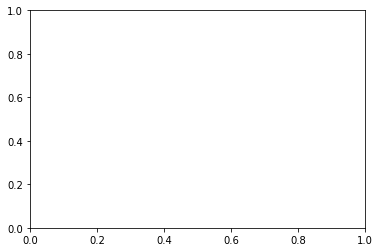

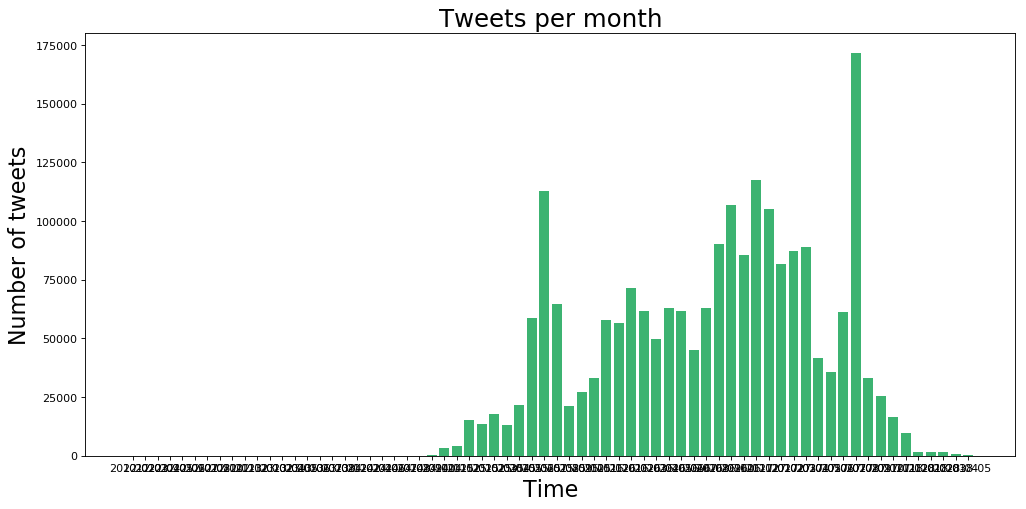

In [43]:
def name_axises(title, xlab, ylab):
    plt.title(title, size=22), plt.xlabel(xlab, size=20), plt.ylabel(ylab, size=20)
#A function for future plotting to save some lines.

data1_timesorted = data1.sort_values("publish_date")
data1_month_days = data1_timesorted["publish_date"].map(lambda x: str(x)[:7])
#if we want only month and days. 
data1_month_count = data1_month_days.value_counts()

fig, ax = plt.subplots()
figure(num=None, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
#ax.tick_params(labelsize=8)
over_time_fig = plt.bar(data1_month_count.index, data1_month_count, color = "#3CB371", align="center")
#for label in over_time_fig.ax.xaxis.get_ticklabels()[::2]:
    #label.set_visible(False)
name_axises("Tweets per month", "Time", "Number of tweets")

### 2.2.x Different user and category stats

In [ ]:
#ta mest aktive og mest fulgte. Sidestilt barchart med to stk 

In [60]:
fig, ax = plt.subplots(2, 2, sharey=True)
fig.set_size_inches(13, 13)

sns.barplot(x="author", y="peak_followers", data=most_pop_authors.tail(10), ax=ax[0][0]).set_title("Most followers")
ax[0][0].set_xticklabels(most_pop_authors.tail(10)["author"], rotation='ve)


SyntaxError: EOL while scanning string literal (<ipython-input-60-3576e226d75f>, line 5)

# 3) Looking into specific research questions

### 3.x What is up with the regions?

### 3.x Did the troll activity change in regards to the american primaries?

### 3.x Are the trolls interacting with each other?